## Imports

In [1]:
import pickle
import re
import sys
import numpy as np
import pandas as pd
from datetime import timedelta
from os.path import abspath, join as opj
from nltk.corpus import stopwords
from scipy.interpolate import interp1d
from scipy.spatial.distance import cdist
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

sys.path.insert(0, abspath('../helpers/'))
from participant import Participant
from experiment import Experiment

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import hypertools as hyp
%matplotlib inline

## Set paths

In [2]:
datadir = '../../data/'
figdir = '../../paper/figs/'
rawdir = opj(datadir, 'raw')
trajs_dir = opj(datadir, 'trajectories')
models_dir = opj(datadir, 'models')

## Load lecture and question text

In [3]:
exp = Experiment()
exp.load_transcript(['forces', 'bos'])
exp.load_questions()
exp.questions.head()

,lecture,question,A,B,C,D
index,,,,,,
1,1,Why is the gravitational attraction between yo...,Neither you nor your computer has enough mass ...,You and your computer are too close for the gr...,Humans are too small to detect the force of gr...,The gravitational attraction between you and y...
2,1,Which of the following is an example of the We...,A neutron in a radioactive Cesium atom is conv...,Light from the sun collides with a satellite o...,Two protons bound together in a Helium nucleus...,A distant galaxy exerts a small but detectable...
3,1,Roughly how many times stronger is the Weak In...,"10,000,000,000,000,000,000,000,000",10,"1,000,000",The Weak Interaction is less strong than gravity
4,1,Why don't you and your computer experience any...,The weak interaction only acts over extremely ...,The weak interaction between you and your comp...,You and your computer have no net charge,Neither you nor your computer has enough mass ...
5,1,Which of the following is a difference between...,Gravity is only ever attractive while the elec...,Gravity is a much more powerful force than ele...,Gravity can only act over large distances whil...,The electromagnetic force can only act over sm...


## Set some parameters

In [4]:
# lecture transcript sliding window length
lecture_wsize = 15
stop_words = exp.cv_params['stop_words']
# vectorizer params
print(exp.cv_params)
# topic model params
print(exp.lda_params)

{'strip_accents': 'unicode', 'stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'n

## Define some functions

In [5]:
def format_text(windows, sw=stop_words):
    # some simple text preprocessing
    clean_text = []
    for chunk in windows:
        no_punc = re.sub("[^a-zA-Z\s'-]+", '', chunk.lower()).replace('-', ' ')
        no_stop = ' '.join([word for word in no_punc.split() if word not in sw])
        clean = re.sub("'+", '', no_stop)
        clean_text.append(clean)
    return clean_text

In [6]:
def _ts_to_secs(ts):
    mins, secs = ts.split(':')
    mins, secs = int(mins), int(secs)
    return timedelta(minutes=mins, seconds=secs).total_seconds()
    

def parse_windows(transcript, wsize):
    # formats lecture transcripts as overlapping sliding windows
    # to feed as documents to topic model
    # also returns timestamps of transcribed speech for interpolation
    lines = transcript.splitlines()
    text_lines = [l for ix, l in enumerate(lines) if ix % 2]
    ts_lines = [_ts_to_secs(l) for ix, l in enumerate(lines) if not ix % 2]    
    windows = []
    timestamps = []
    for ix in range(1, wsize):
        start, end = 0, ix
        windows.append(' '.join(text_lines[start : end]))
        timestamps.append((ts_lines[start] + ts_lines[end - 1]) / 2)

    for ix in range(len(ts_lines)):
        start = ix
        end = ix + wsize if ix + wsize <= len(text_lines) else len(text_lines)
        windows.append(' '.join(text_lines[start : end]))
        timestamps.append((ts_lines[start] + ts_lines[end - 1]) / 2)
        
    return windows, timestamps

In [7]:
def interp_lecture(lec_traj, timestamps):
    # interpolates lecture trajectories to 1 vector per second
    new_tpts = np.arange(timestamps[-1])
    interp_func = interp1d(timestamps, lec_traj, axis=0)
    return interp_func(new_tpts)

In [8]:
def get_top_words(cv, lda, n_words=10):
    topic_words = {}
    vocab = cv.get_feature_names()
    for topic, component in enumerate(lda.components_):
        word_ix = np.argsort(component)[::-1][:n_words]
        topic_words[topic] = [vocab[i] for i in word_ix]
    return topic_words

## process and reformat text

In [9]:
# get sliding windows & timestamps from lecture transcripts
ff_windows, ff_timestamps = parse_windows(exp.forces_transcript, lecture_wsize)
bos_windows, bos_timestamps = parse_windows(exp.bos_transcript, lecture_wsize)

# remove punctuation, stop-words, digits, etc.
ff_windows = format_text(ff_windows)
bos_windows = format_text(bos_windows)

# format quiz questions and correct answers
grouped_qdf = exp.questions.groupby('lecture')
gen_qs, ff_qs, bos_qs = grouped_qdf['question'].apply(format_text)
all_qs = ff_qs + bos_qs + gen_qs
# gen_correct, ff_correct, bos_correct = grouped_qdf['A'].apply(format_text)
# all_ans_correct = ff_correct + bos_correct + gen_correct

# format all answers
all_ans = exp.questions.loc[:, 'A':].apply(format_text, axis=1).to_dict()

## Model lectures and quiz questions

In [10]:
# create corpus
corpus = ff_windows + bos_windows + all_qs

# fit CountVectorizer model, vectorize corpus for fitting topic model
tf_vectorizer = CountVectorizer(**exp.cv_params).fit(corpus)
corpus_tf = tf_vectorizer.transform(corpus)
# vectorize lecture windows
ff_lec_tf = tf_vectorizer.transform(ff_windows)
bos_lec_tf = tf_vectorizer.transform(bos_windows)
# vectorize questions
ff_qs_tf = tf_vectorizer.transform(ff_qs)
bos_qs_tf = tf_vectorizer.transform(bos_qs)
gen_qs_tf = tf_vectorizer.transform(gen_qs)

# fit LatentDirichletAllocation model
lda = LatentDirichletAllocation(**exp.lda_params).fit(corpus_tf)
# transform lecture windows
ff_traj = lda.transform(ff_lec_tf)
bos_traj = lda.transform(bos_lec_tf)
# transform questions
ff_qs_vecs = lda.transform(ff_qs_tf)
bos_qs_vecs = lda.transform(bos_qs_tf)
gen_qs_vecs = lda.transform(gen_qs_tf)

# interpolate lecture trajectories to 1 sample per second
ff_traj = interp_lecture(ff_traj, ff_timestamps)
bos_traj = interp_lecture(bos_traj, bos_timestamps)

## Concat question vectors, model answers

In [11]:
qs_concat = np.concatenate((ff_qs_vecs, bos_qs_vecs, gen_qs_vecs))
all_questions = np.empty((39, 25), dtype=np.float64)
all_answers = np.empty((39, 4, 25), dtype=np.float64)
for qID, q_vec in enumerate(qs_concat):
    all_questions[qID] = q_vec
    all_answers[qID] = lda.transform(tf_vectorizer.transform(all_ans[qID + 1]))

In [12]:
exp.forces_traj = ff_traj
exp.bos_traj = bos_traj
exp.question_vectors = all_questions
exp.answer_vectors = all_answers

/opt/conda/lib/python3.7/site-packages/hypertools/plot/plot.py:414: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


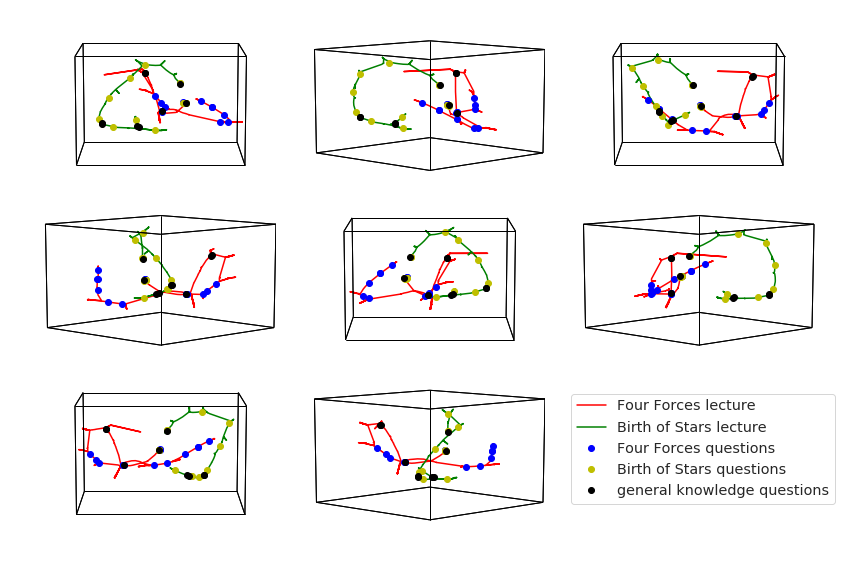

In [13]:
fig, axarr = plt.subplots(3, 3, subplot_kw={'projection': '3d'}, gridspec_kw={'wspace': -.1, 'hspace': -.1})
fig.set_size_inches(15, 10)
axarr = axarr.flatten()

for ax, azim in zip(axarr, range(0, 360, 45)):
    ax = exp.plot(lectures=['forces', 'bos'], 
                  questions=['forces', 'bos', 'general'], 
                  fmt=['r-', 'g-', 'bo', 'yo', 'ko'], 
                  reduce='UMAP', 
                  azim=azim, 
                  show=False, 
                  ax=ax)
    
axarr[-1].axis('off')
fig.legend(['Four Forces lecture', 'Birth of Stars lecture', 
            'Four Forces questions', 'Birth of Stars questions', 'general knowledge questions'],
           loc='lower right', bbox_to_anchor=(.78, .09), fontsize='x-large')
# fig.savefig(opj(figdir, 'lectures-questions-3d-9.pdf'), bbox_inches='tight')
fig

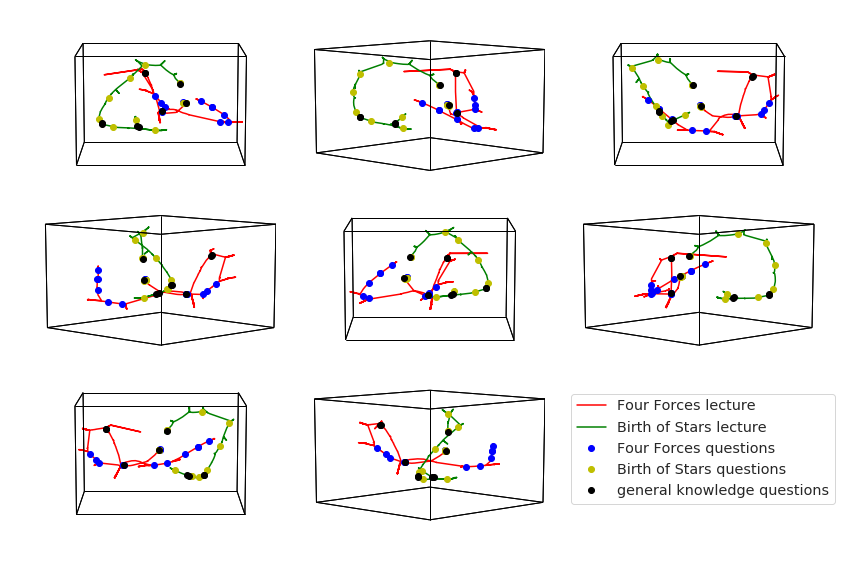

In [14]:
fig, axarr = plt.subplots(3, 3, subplot_kw={'projection': '3d'}, gridspec_kw={'wspace': -.1, 'hspace': -.1})
fig.set_size_inches(15, 10)
axarr = axarr.flatten()

for ax, azim in zip(axarr, range(0, 360, 45)):
    ax = exp.plot(lectures=['forces', 'bos'], 
                  questions=['forces', 'bos', 'general'], 
                  fmt=['r-', 'g-', 'bo', 'yo', 'ko'], 
                  reduce='UMAP', 
                  azim=azim, 
                  show=False, 
                  ax=ax)
    
axarr[-1].axis('off')
fig.legend(['Four Forces lecture', 'Birth of Stars lecture', 
            'Four Forces questions', 'Birth of Stars questions', 'general knowledge questions'],
           loc='lower right', bbox_to_anchor=(.78, .09), fontsize='x-large')
# fig.savefig(opj(figdir, 'lectures-questions-3d-9.pdf'), bbox_inches='tight')
fig

In [15]:
topic_words = get_top_words(tf_vectorizer, lda)
for topic, words in topic_words.items():
    print(f'topic {topic}:\n\t{", ".join(words)}')

topic 0:
	universe, attracting, large, mass, another, gravity, following, objects, itll, keep
topic 1:
	energy, pressure, mass, little, bit, actually, enough, get, plus, keep
topic 2:
	hydrogen, deuterium, fusion, first, step, fused, still, ignition, well, reaction
topic 3:
	force, scales, gravity, strength, macro, electromagnetic, times, huge, apply, weak
topic 4:
	force, weak, least, hardest, gravity, us, little, move, bit, visualize
topic 5:
	helium, four, atomic, mass, energy, star, keeps, high, super, hydrogen
topic 6:
	two, electrons, nucleus, atom, first, coulomb, protons, well, draw, may
topic 7:
	charge, concentrations, lump, neutral, big, attract, positive, force, anything, mass
topic 8:
	proton, one, weak, interaction, cesium, neutrons, get, example, protons, give
topic 9:
	force, go, strong, frames, detail, mind, moving, connected, keep, lot
topic 10:
	sun, star, gets, sequence, process, main, tell, approach, becoming, say
topic 11:
	force, called, going, one, electrostatic

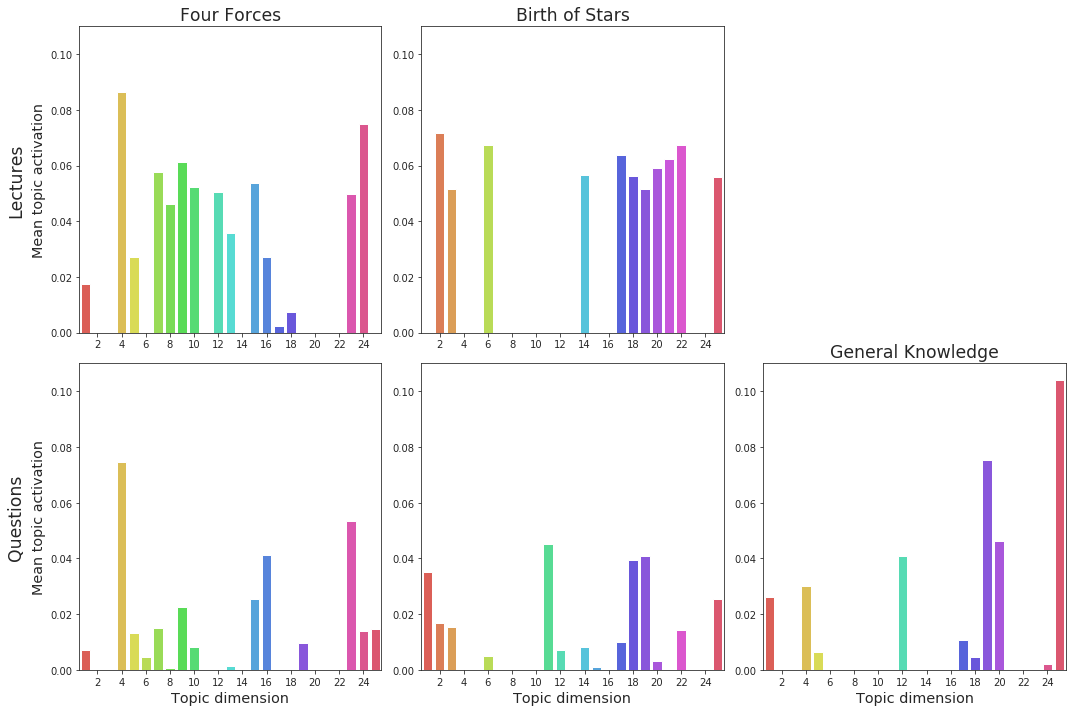

In [20]:
sns.set_style('ticks')
fig, axarr = plt.subplots(2, 3)
fig.set_size_inches(15, 10)
axarr = axarr.flatten()

for i, traj in enumerate([ff_traj, bos_traj, None, ff_qs_vecs, bos_qs_vecs, gen_qs_vecs]):
    ax = axarr[i]
    if traj is None:
        ax.axis('off')
        continue
        
    topic_vars = np.var(traj, axis=0)
    ax.bar(x=list(range(1, 26)), height=topic_vars, color=sns.color_palette('hls', 25))
    ax.set_ylim(0, .11)
    ax.set_xlim(.5, 25.5)
    ax.set_xticks(list(range(2, 26, 2)))
    
    if i == 0:
        ax.set_ylabel('Mean topic activation', fontsize='x-large')
        ax.set_title('Four Forces', fontsize='xx-large')
        ax.annotate('Lectures', xy=(-.5, .5), xycoords=ax.yaxis.label, 
                    size='xx-large', rotation=90, ha='right', va='center')
    elif i == 1:
        ax.set_title('Birth of Stars', fontsize='xx-large')
    elif i == 3:
        ax.set_ylabel('Mean topic activation', fontsize='x-large')
        ax.annotate('Questions', xy=(-.5, .5), xycoords=ax.yaxis.label, 
                    size='xx-large', rotation=90, ha='right', va='center')
    elif i == 5:
        ax.set_title('General Knowledge', fontsize='xx-large')
        
    if i > 2:
        ax.set_xlabel('Topic dimension', fontsize='x-large')
        

plt.tight_layout()
# plt.savefig(opj(figdir, 'topics-vars.pdf'), bbox_inches='tight')
plt.show()

## Save trajectories and fit models

In [17]:
# np.save(opj(trajs_dir, 'forces_lecture'), ff_traj)
# np.save(opj(trajs_dir, 'bos_lecture'), bos_traj)
# np.save(opj(trajs_dir, 'all_questions'), all_questions)
# np.save(opj(trajs_dir, 'all_answers'), all_answers)
# np.save(opj(rawdir, 'forces_window'), ff_windows)
# np.save(opj(rawdir, 'bos_window'), bos_windows)
# np.save(opj(models_dir, 'fit_CV'), tf_vectorizer)
# np.save(opj(models_dir, 'fit_LDA'), lda)